In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import datasets

In [2]:
dataset = datasets.load_iris()

X = dataset['data']
labels = dataset['target']

In [3]:
# Set random weights with the same dimensions as the data
# ... or set weights as grid
W = np.random.random(size=X.shape)

In [4]:
# Use networkx to define topology and neighbourhood connections
# The i'th row of the weights maps to the i'th node in the network

# Using a lattice as an example
s = int(np.ceil(np.sqrt(W.shape[0])))
G = nx.grid_2d_graph(m=s, n=s)

# Map coordinates to index and index to coordinates
c2i = {c: i for i, c in enumerate(G.nodes())}
i2c = {v: k for k, v in c2i.items()}

In [5]:
# If there are more nodes than weights, append difference to match size
diff = np.abs(len(G.nodes()) - W.shape[0])
if diff > 0:
    W = np.concatenate([W, np.random.random(size=(diff, W.shape[1]))])

In [6]:
# Function for learning rate
def learning_rate(s, k):
    return np.exp(s * k)

# Function for neighbourhood restraint
def restraint(G, best, n):
    dist = nx.shortest_path_length(G, source=best, target=n)
    return 1.0 / (1.0 + dist)

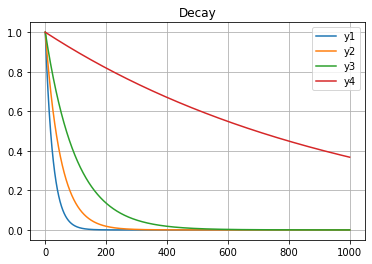

In [7]:
m = 1000

x = np.linspace(0, m, 100000)
y1 = learning_rate(x, k=-(1/25))
y2 = learning_rate(x, k=-(1/50))
y3 = learning_rate(x, k=-(1/100))
y4 = learning_rate(x, k=-(1/1000))

plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y2')
plt.plot(x, y3, label='y3')
plt.plot(x, y4, label='y4')
plt.grid()
plt.title("Decay")
plt.legend()
plt.show()

In [8]:
# Keep track of which unit (neuron) won what
winners = {i: [] for i in range(W.shape[0])}

max_iter = 75000

# Start training loop
for s in range(max_iter):
    # Pick random data point
    r_idx = np.random.randint(X.shape[0])
    x = X[r_idx, :]

    # Find the best matching unit (BMU) using Euclidean distance
    dists = [np.linalg.norm(x - W[i, :]) for i in range(W.shape[0])]
    best_idx = np.argmin(dists)

    # Set learning rate
    k = -(1/1000)
    a = learning_rate(s, k)
    
    # Update weights
    W[best_idx, :] = W[best_idx, :] + a * (x - W[best_idx, :])
    
    # Add the index of the data point to the "won" list
    winners[best_idx].append(r_idx)

    # Update weights of neighbours
    immediate_n = list(G[i2c[best_idx]])
    for n in immediate_n:
        W[c2i[n], :] = W[c2i[n], :] + restraint(G, i2c[best_idx], n) * a * (x - W[c2i[n], :])

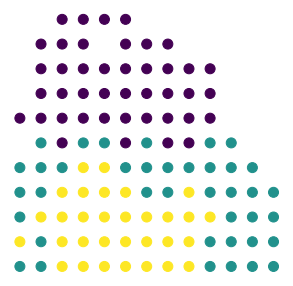

In [9]:
# Match unit to most "won" data point, else sign no label
def best_match(idxs):
    idx = None
    if len(idxs) > 0:
        idx = max(idxs, key=idxs.count)
    
    return idx

unit_match = {i: best_match(idxs) for i, idxs in winners.items()}

# Match unit with the label, if assigned index
unit_label = {i: labels[idx] for i, idx in unit_match.items() if idx}

# Plot the results as a scatter plot (optional, try heat map)
results = np.array([list(i2c[k]) for k in unit_label.keys()])
pred = list(unit_label.values())

plt.figure(figsize=(5, 5))
plt.scatter(results[:, 0], results[:, 1], c=pred, s=100)
plt.axis('off')
plt.show()